# Querying Scalar Quantities and Annually Averaged Timeseries

ACCESS-OM2 computes globally averaged quantities that are stored in `ocean_scalars.nc` files. This notebook shows how we do data discovery on scalar quantities and plot them as time series.

In [1]:
import intake
import matplotlib.pyplot as plt
import pandas as pd
from dask.distributed import Client

In [2]:
client = Client(threads_per_worker=1)
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42923 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/42923/status,
Dashboard: /proxy/42923/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42177,Workers: 28
Dashboard: /proxy/42923/status,Total threads: 28
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:32815,Total threads: 1
Dashboard: /proxy/36681/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:39769,


Open ACCESS-NRI default catalog:

In [4]:
catalog = intake.cat.access_nri

### Querying Scalar Quantities

First we need to choose an experiment.

An **experiment** is a particular model run with a given forcing.  It is composed of several independent runs of the model.

Here is a list of experiments from the 0.25 degree ACCESS-OM2 physics only global configuration with JRA55-do v1.4 IAF Interannual Forcing, following the OMIP-2 protocol.

In [15]:
cat_subset = catalog.search(name='.*025deg_jra55_iaf_omip2_cycle.*')
sorted(set(cat_subset.df['name']))

['025deg_jra55_iaf_omip2_cycle1',
 '025deg_jra55_iaf_omip2_cycle2',
 '025deg_jra55_iaf_omip2_cycle3',
 '025deg_jra55_iaf_omip2_cycle4',
 '025deg_jra55_iaf_omip2_cycle5',
 '025deg_jra55_iaf_omip2_cycle6']

An experiment is composed of many different **variables** which are stored at different **frequencies**.

Let's use the catalog subset to see which frequencies are available for a certain cycle:

In [14]:
print('\n'.join(f"frequency='{f}'" for f in set(cat_subset['025deg_jra55_iaf_omip2_cycle5'].df['frequency'])))

frequency='1mon'
frequency='1yr'
frequency='1day'
frequency='fx'


Here are all of the variables that are stored at the frequency of `1 monthly` and also are files of the form `ocean/ocean_scalar.nc`.

In [9]:
pd.set_option("display.max_rows", 200) # to ensure all rows of the pandas DataFrame are displayed
var_search = cat_subset['025deg_jra55_iaf_omip2_cycle5'].search(frequency = '1mon', filename = 'ocean_scalar.nc')
one_file = var_search.df.iloc[0]
pd.DataFrame({var:one_file[var] for var in ['variable', 'variable_long_name', 'variable_standard_name', 'variable_units']})

,variable,variable_long_name,variable_standard_name,variable_units
0,total_mass_seawater,total mass of liquid seawater,sea_water_mass,kg
1,total_volume_seawater,total volume of liquid seawater,sea_water_volume,m^3
2,eta_adjust,global eta adjustment to include steric effect in Boussinesq fluid,,m
3,pbot_adjust,pbot adjustment to counteract spurious mass source in Boussinesq fluid,,dbar
4,rhoave,global mean ocean in-situ density from ocean_density_mod,,kg/m^3
5,eta_global,global ave eta_t plus patm_t/(g*rho0),,meter
6,temp_global_ave,Global mean temp in liquid seawater,sea_water_potential_temperature,deg_C
7,salt_global_ave,Global mean salt in liquid seawater,sea_water_salinity,psu
8,salt_surface_ave,Global mass weighted mean surface salt in liquid seawater,,psu
9,ke_tot,Globally integrated ocean kinetic energy,,10^15 Joules


Say, we want to look at one of these variables such as "total_ocean_salt".  We use open it using `intake` like this:

In [10]:
experiment = "025deg_jra55_iaf_omip2_cycle5"
variable = "total_ocean_salt"
var_search = catalog[experiment].search(
                    variable = variable, 
                    frequency = '1mon')
darray = var_search.to_dask()
darray = darray[variable]
darray

<xarray.DataArray 'total_ocean_salt' (time: 732, scalar_axis: 1)> Size: 3kB
dask.array<concatenate, shape=(732, 1), dtype=float32, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * scalar_axis  (scalar_axis) float64 8B 0.0
  * time         (time) datetime64[ns] 6kB 1958-01-14T12:00:00 ... 2018-12-14...
Attributes:
    long_name:      total mass of salt in liquid seawater
    units:          kg/1e18
    valid_range:    [-1.e+02  1.e+10]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT

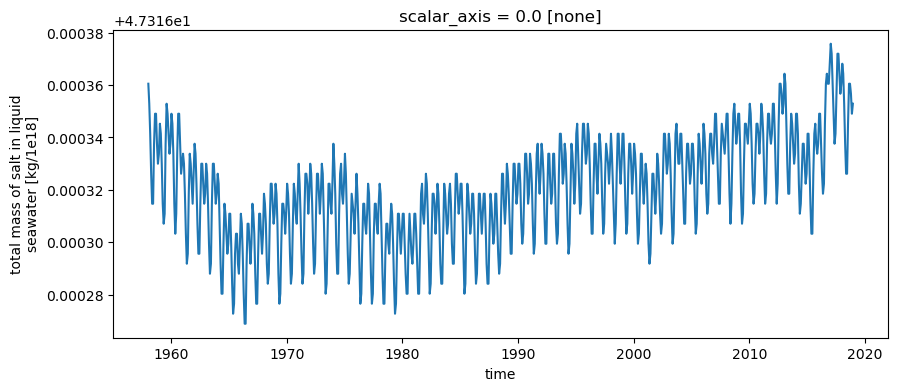

In [12]:
darray.plot(figsize = (10,4));

Suppose we want to compare this variable across several different experiments. Using our list of experiments from above (`cat_subset`), we can select the six 61-year cycles of 1 Jan 1958 to 1 Jan 2019 from the list of experiments above. These cycles are sequential, with each cycle starting where the previous one ended, with the initialization date reset to 1959. Here we show how to plot some quantities to compare those cycles.

For each experiment cycle, extract out the variable of interest and store the result in a dictionary using the experiment as the key. Notice we are computing the variables and storing the results for later visualization.

Here we add an exception for in case a experiment cycle does not have `total_ocean_salt` as an output.

In [16]:
results = {}
variable = "total_ocean_salt"
for experiment in cat_subset:
  try:
    var_search = catalog[experiment].search(
                        variable = variable, 
                        frequency = '1mon')
    darray = var_search.to_dask()
    darray = darray[variable]
    results[experiment] = darray
  except KeyError:
    print(f"No {variable} in {experiment}")

Now, plot the results

In [ ]:
plt.figure(figsize = (12, 4))
for experiment, result in results.items():
    result.plot(label = experiment)
plt.legend();

### Annually Averaged Scalar Timeseries
This section presents how the data are resampled onto annual averages.

Note that the previous timeseries are monthly so we will use `resample` and `mean`.

In [19]:
results_annual_average = dict()
for experiment, result in results.items():
    results_annual_average[experiment] = results[experiment].resample(time = '1YE').mean('time')

In [ ]:
plt.figure(figsize = (12, 4))
for experiment, result in results_annual_average.items():
    result.plot(label = experiment)
plt.legend();